In [1]:
from variables import countries_msft,countries_eubucco
from functions import check_and_read_markdown

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


## Compute country metrics

In [3]:
out_msft = {country:{} for country in countries_msft}
out_eubucco = {country:{} for country in countries_eubucco}

In [4]:
for country in countries_msft:

    df_msft = pd.read_csv(f'../overviews/overview-msft/{country}_overview.csv')

    if country in countries_eubucco:    
        df_eubucco = pd.read_csv(f'../overviews/overview-v0_1/{country}_overview.csv')
        iterator = ((out_msft,df_msft),(out_eubucco,df_eubucco))
    
    else: iterator = [(out_msft,df_msft)]

    for d,df in iterator:
        d[country]['Total Footprint Area'] = round(df.a_tot.sum())
        d[country]['Total Footprint Number'] = round(df.bldgs_n_tot.sum())

/tmp/ipykernel_12494/827869101.py:3: DtypeWarning: Columns (60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df_msft = pd.read_csv(f'../overviews/overview-msft/{country}_overview.csv')


In [5]:
dims = ['Total Footprint Area','Total Footprint Number']

In [6]:
out_ratio = {country: {dim : round(out_eubucco[country][dim]/out_msft[country][dim],2) 
                       if country in countries_eubucco
                       else 0 
                       for dim in dims} 
                       for country in countries_msft}

## Compute regional metrics

In [7]:
reg_prints = {country : '' for country in countries_msft}

for country in countries_eubucco:

    df_msft = pd.read_csv(f'../overviews/overview-msft/{country}_overview.csv')
    df_eubucco = pd.read_csv(f'../overviews/overview-v0_1/{country}_overview.csv')
    df_eubucco['id'] = [s.split('-')[1] for s in df_eubucco.id]
    df_msft['id'] = [s.split('-')[1] for s in df_msft.id]
    df = pd.merge(df_msft,df_eubucco,on="id",suffixes=("_msft","_v01"))

    gb = pd.DataFrame((df.groupby('region_msft')['a_tot_msft'].sum() -  df.groupby('region_msft')['a_tot_v01'].sum()) / df.groupby('region_msft')['a_tot_v01'].sum())

    gb.index.names = ['Region']
    gb.columns = ['Diff. MSFT/v0.1']

    reg_prints[country] = gb.round(2).to_markdown()


/tmp/ipykernel_12494/1309151786.py:5: DtypeWarning: Columns (60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df_msft = pd.read_csv(f'../overviews/overview-msft/{country}_overview.csv')


## Make figures

/tmp/ipykernel_12494/2636257241.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8,6))
/tmp/ipykernel_12494/2636257241.py:3: DtypeWarning: Columns (60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df_msft = pd.read_csv(f'../overviews/overview-msft/{country}_overview.csv')


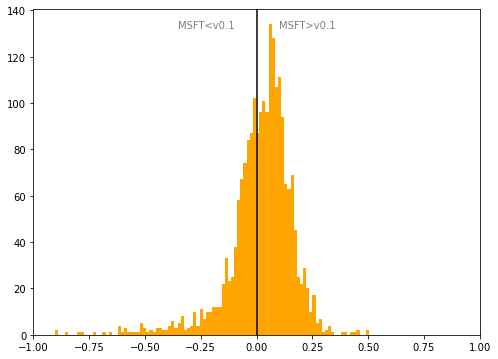

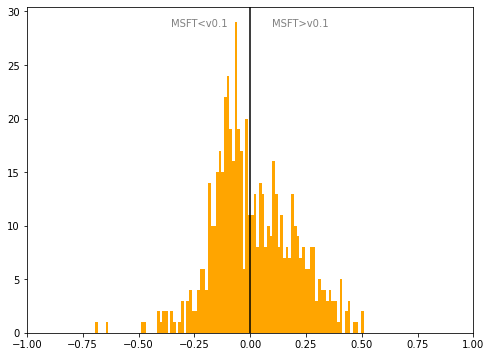

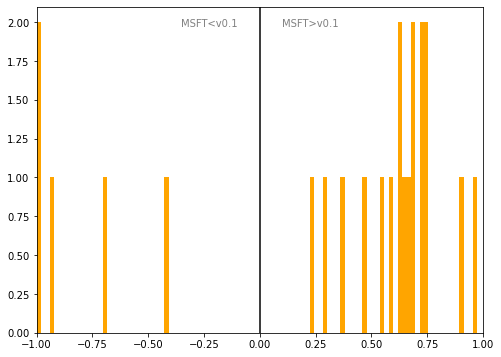

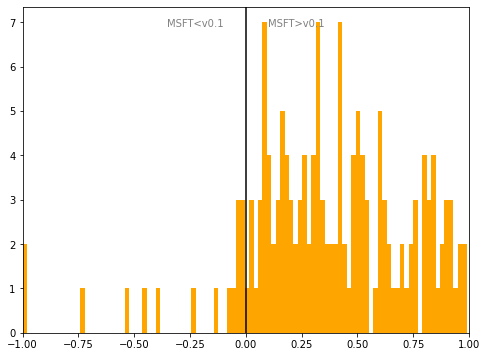

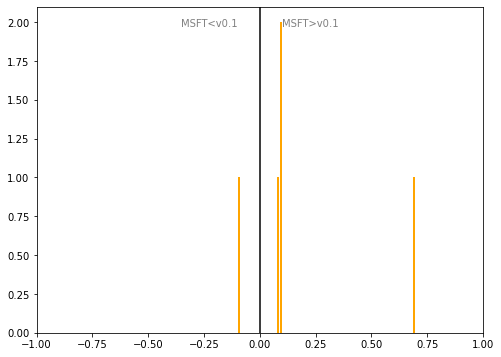

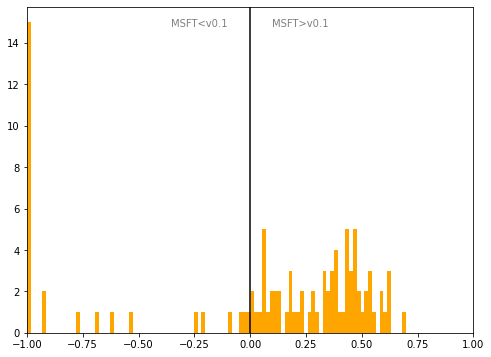

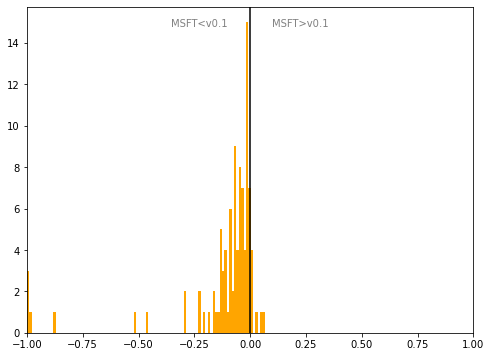

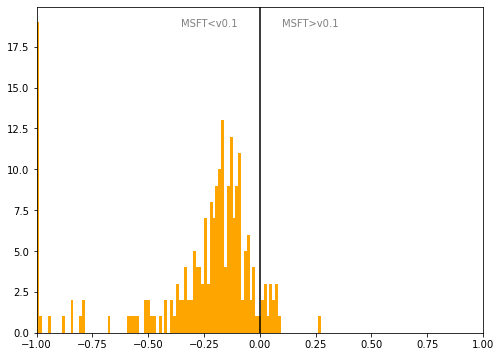

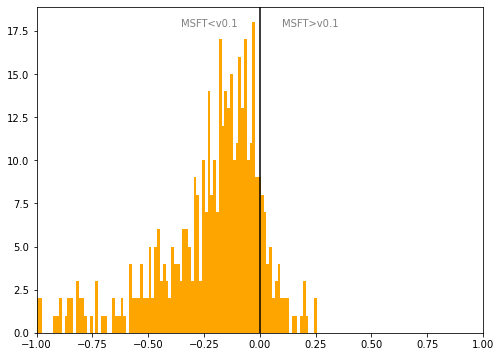

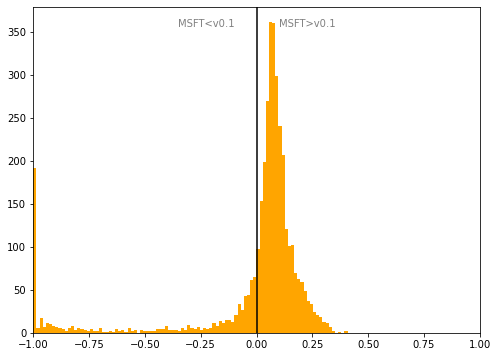

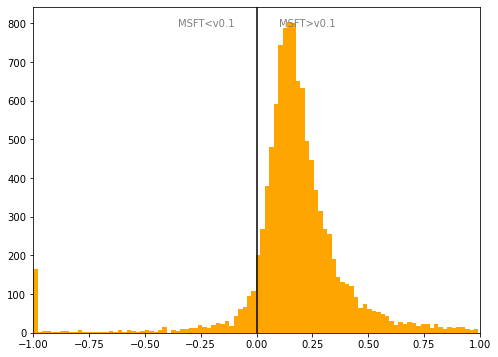

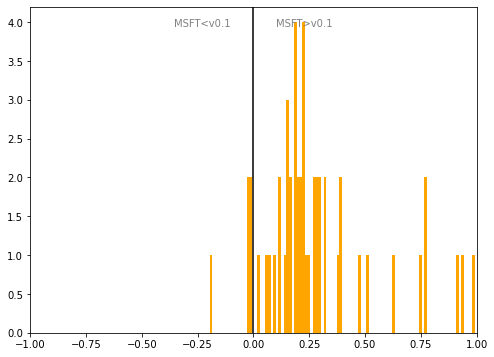

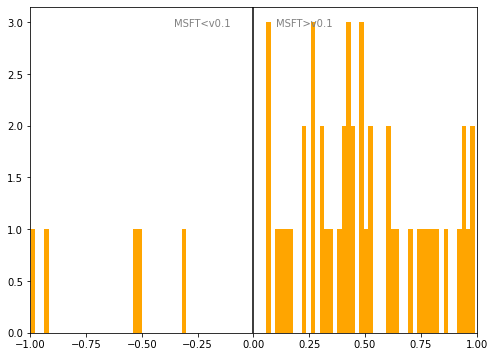

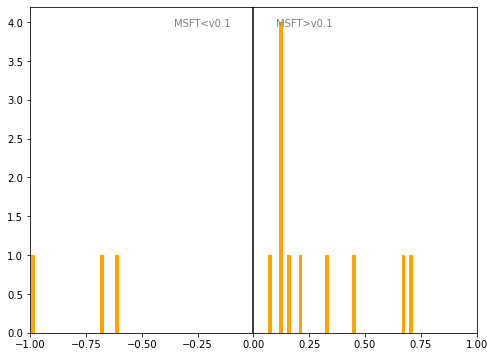

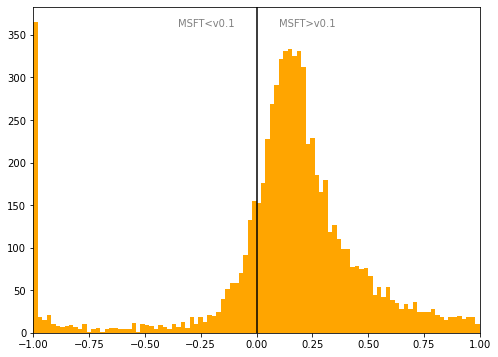

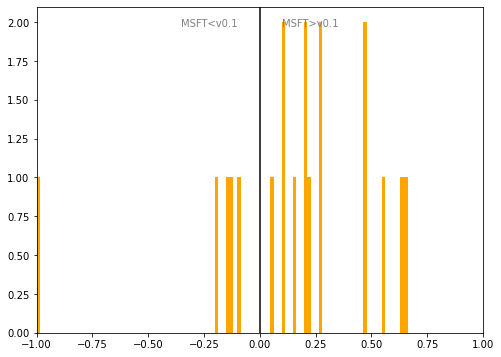

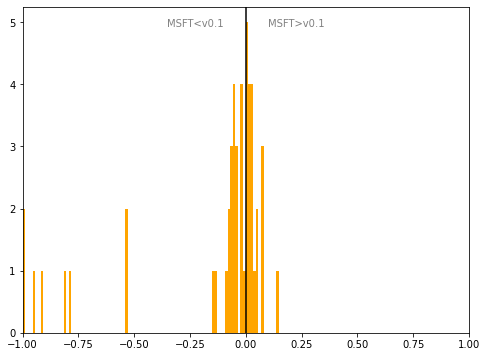

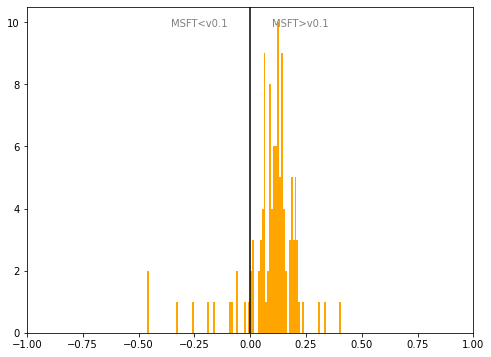

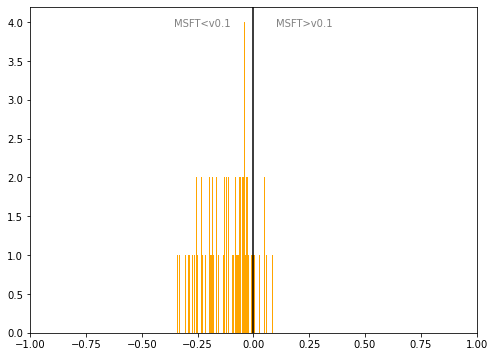

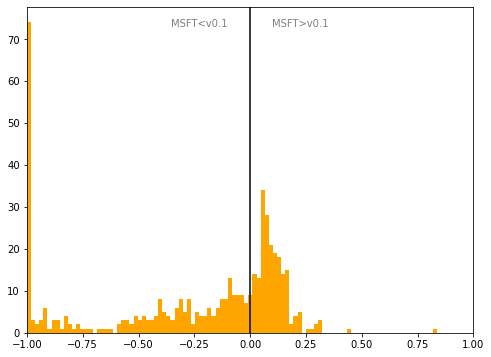

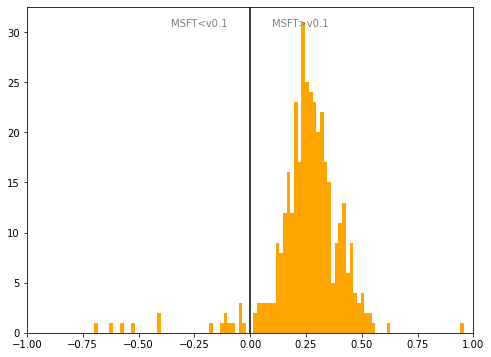

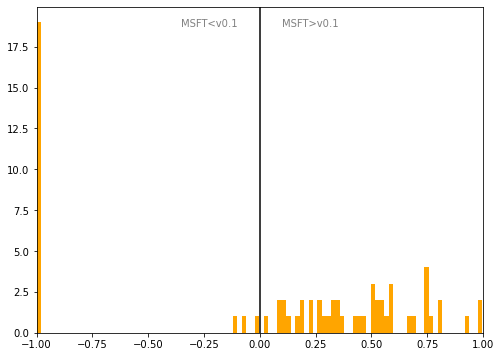

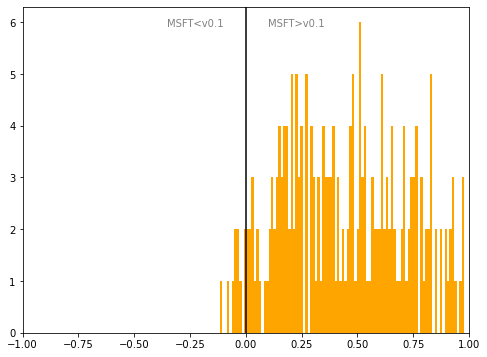

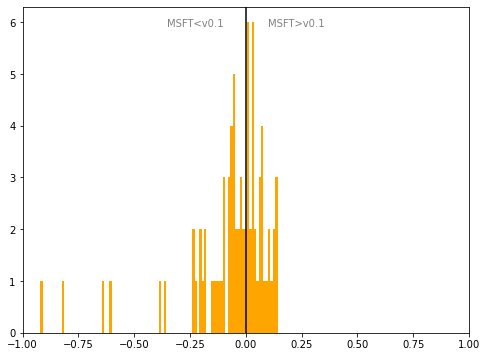

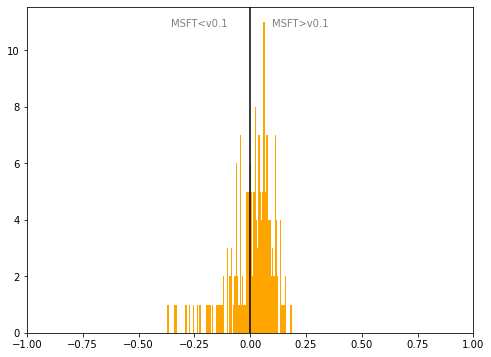

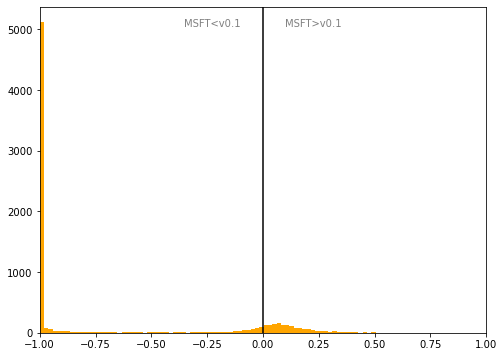

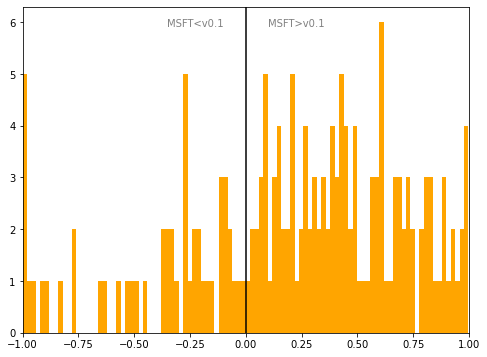

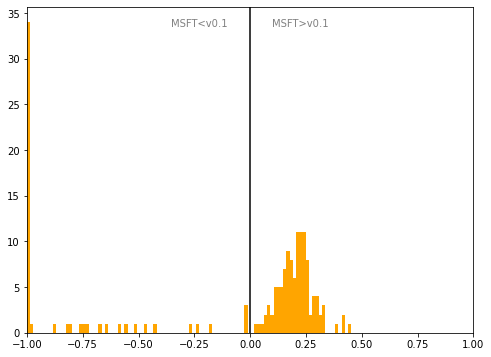

In [8]:
for country in countries_eubucco:

    df_msft = pd.read_csv(f'../overviews/overview-msft/{country}_overview.csv')
    df_eubucco = pd.read_csv(f'../overviews/overview-v0_1/{country}_overview.csv')
    df_eubucco['id'] = [s.split('-')[1] for s in df_eubucco.id]
    df_msft['id'] = [s.split('-')[1] for s in df_msft.id]
    df = pd.merge(df_msft,df_eubucco,on="id",suffixes=("_msft","_v01"))

    df['diff_a_tot'] = (df.a_tot_msft - df.a_tot_v01)/df.a_tot_v01    

    fig, ax = plt.subplots(figsize=(8,6))
    ax.hist(df['diff_a_tot'][(df['diff_a_tot'] >= -1) & (df['diff_a_tot'] <= 1)],bins=100,color='orange')
    ax.axvline(x=0, color='black', linestyle='-')
    ax.text(0.55, 0.95, 'MSFT>v0.1', color='grey', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.45, 0.95, 'MSFT<v0.1', color='grey', verticalalignment='center', horizontalalignment='right', transform=ax.transAxes)
    ax.set_xlim(-1, 1)
    plt.savefig(f'../imgs/city_diff/{country}_city_diff.png',facecolor='white', transparent=False,bbox_inches='tight')

## Write text

In [9]:
dims_print = {country:'' for country in countries_msft}

for country in countries_msft:
    for dim in dims: 
        dims_print[country] += f'|{dim}|{out_eubucco[country][dim] if country in countries_eubucco else 0:,}|{out_msft[country][dim]:,}|{out_ratio[country][dim]:.0%}|\n' 

In [10]:
img_print = {country: f'### City-level difference EUBUCCO/MSFT \n ![City-level difference EUBUCCO/MSFT](../imgs/city_diff/{country}_city_diff.png)' if country in countries_eubucco else '' for country in countries_msft}

In [15]:
for country in countries_msft:
    # Sample markdown content
    markdown_content = f"""
# {country.capitalize()}
## Available data EUBUCCO / MSFT

| Dimension    | EUBUCCO v0.1 | MSFT | Ratio |
| -------- | ------- | ------- | ------- |
{dims_print[country]}

## Statistics

{img_print[country]}

## Regional breakdown

{reg_prints[country]}

## Maps

## Outliers

## Known issues
{check_and_read_markdown(f"../factsheets/{country}_analysis.md","Known issues")}

## Recommendations
"""

    # Write the content to a markdown file
    with open(f"../factsheets/{country}_analysis.md", "w") as file:
        file.write(markdown_content)
